# KerasTuner para la construccion del mejor modelo

### Cargar datos

In [1]:
# librerias
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import string
import tensorflow as tf

from tensorflow.keras import regularizers

# libreria para trabajar con las bases de datos 
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2024-11-06 09:01:54.805292: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-06 09:01:55.293136: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-06 09:01:55.694702: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1730901716.280047   15944 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1730901716.409854   15944 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-06 09:01:57.419075: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

Found 27455 images belonging to 24 classes.
Found 1425 images belonging to 24 classes.
Found 7172 images belonging to 24 classes.


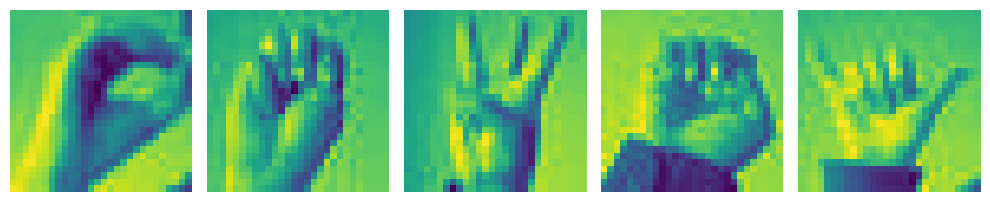

In [2]:
# ruta de los archivos
train_dir = './sign-language-img/Train'
test_dir = './sign-language-img/Test'

# data generator
train_datagen = ImageDataGenerator(rescale=1/255)
test_datagen = ImageDataGenerator(rescale=1/255, validation_split=0.2)

# generator para test, training y validation
# para datos de entrenamiento
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (28, 28),
    batch_size = 128,
    class_mode = 'categorical',
    color_mode = 'grayscale',
    subset = 'training'
)

# para daros de validacion
validation_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (28, 28),
    batch_size = 128,
    class_mode = 'categorical',
    color_mode = 'grayscale',
    subset = 'validation'
)

# para daros de prueba
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (28, 28),
    batch_size = 128,
    class_mode = 'categorical',
    color_mode = 'grayscale'
)

# clases
classes = [char for char in string.ascii_uppercase if char != 'J' if char != 'Z']

# funcion para mostrar las imagenes
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize = (10, 10))
    axes = axes.flatten()

    for img, ax in zip(images_arr, axes):
        ax.imshow(img[:,:,0])
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# mostrar 5 imagenes
sample_training_images, _ = next(train_generator)
plotImages(sample_training_images[:5])

### Modelo a trabajar

El modelo con el que vamos a trabajar es el mismo con el que hemos venido trabajando. Vamos a definirlo

In [3]:
# funcion para generalizar la creacion del modelo
def get_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(75, (3,3), activation='relu'),
        tf.keras.layers.MaxPool2D((2,2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, kernel_regularizer = regularizers.l2(1e-5), activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(128, kernel_regularizer = regularizers.l2(1e-5), activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(len(classes), activation='softmax')
    ])
    return model

### Implementando Autotuner

Vamos a cargar la libreria kerastuner y keras

In [5]:
import kerastuner as kt
from tensorflow import keras

/tmp/ipykernel_15944/2517507747.py:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


Para esta ocasión crearemos un nuevo constructor de modelos, este recibirá como parámetros un objeto tuner que determinará las variaciones de diferentes hiperparámetros.

- Arquitectura general, donde agregaremos una capa de convolución, Max Pooling y aplanamiento de manera fija

- Primer variable del constructor: La cantidad de neuronas en la siguiente capa oculta, se inicializará en 32 e incrementará hasta 512 dando saltos de 32 en 32.

- La cantidad de neuronas de la siguiente capa será el objeto iterador. El resto de la red se mantendrá estable.

- Variaciones en el learning rate, donde empezaremos el modelo con 3 posibles learning rate: 0.01, 0.001 y 0.0001.

- Al momento de compilar el modelo definiremos Adam como optimizador, sin embargo, llamaremos directamente a la clase y le entregaremos el objeto iterador. El resto de parámetros seguirán iguales.

In [8]:
def constructor_modelos(hp):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(75, (3,3), activation='relu', input_shape = (28,28,1)))
    model.add(tf.keras.layers.MaxPoll2d((2,2)))
    model.add(tf.keras.layers.Flatten())

    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
    model.add(tf.keras.layers.Dense(units=hp_units, activation='relu', kernel_regularizer=regularizers.l2(1e-5)))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(len(classes), activation='softmax'))

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer=keras.optimizers.Adam(
        learning_rate=hp_learning_rate), 
        loss='categorical_crossentropy', 
        metrics=['accuracy'])
    return model

Esta función será la materia prima del tuner, el cual hará pruebas con todas las combinatorias para encontrar el modelo más optimo.